# 09.2c: The Token in the Gap

**Search for a token between BH #0 and BH #1**

From 09.2b, we found that BH #1 is separated from BH #0 by **exactly 2ε**. This suggests they're in adjacent lattice cells with a one-cell gap between them.

## The Hypothesis

If the separation is 2ε in the L∞ norm, then:
- There exists a dimension where they differ maximally
- In that dimension, they're separated by 2 ULP steps
- There's room for a token "in between" them

**If we find a token:**
- At distance ~ε from both black holes
- Positioned between them in the critical dimension
- That would be **strong evidence of lattice structure**

Let's find out!

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
PAIRWISE_FILE = "neighborhood_pairwise_distances.safetensors"
DISTANCES_KEY = "distances_linf"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Known from 09.2b
BH_0_LOCAL_IDX = 0  # Local index among the 13 black holes
BH_1_LOCAL_IDX = 1  # The rogue

EPSILON_MULTIPLIER = 2.0  # 2×ULP
SEARCH_TOLERANCE = 1.2  # Look for tokens within 1.2× ε of each BH

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading pairwise distances...")
pairwise_data = load_file(data_dir / PAIRWISE_FILE)
distances = pairwise_data[DISTANCES_KEY]
unique_vectors = pairwise_data[UNIQUE_VECTORS_KEY]
unique_token_ids = pairwise_data[UNIQUE_TOKEN_IDS_KEY]

n_unique = len(unique_vectors)
print(f"  Unique vectors: {n_unique:,}")
print()

print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
print()

print("✓ Data loaded")

Loading pairwise distances...
  Unique vectors: 499

Loading black hole mask...

✓ Data loaded


## Compute ε

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

typical_magnitude = unique_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = EPSILON_MULTIPLIER * ulp

print(f"ε = {epsilon:.6e}")
print(f"Search tolerance: {SEARCH_TOLERANCE}× ε = {SEARCH_TOLERANCE * epsilon:.6e}")
print()

ε = 3.051758e-05
Search tolerance: 1.2× ε = 3.662109e-05



## Identify BH #0 and BH #1

In [5]:
print("Identifying black hole vectors...\n")

# Find black hole indices
is_bh = black_hole_mask[unique_token_ids]
bh_indices = torch.where(is_bh)[0]

# Get global indices for BH #0 and BH #1
bh0_idx = bh_indices[BH_0_LOCAL_IDX].item()
bh1_idx = bh_indices[BH_1_LOCAL_IDX].item()

print(f"BH #0:")
print(f"  Local index:  {BH_0_LOCAL_IDX}")
print(f"  Global index: {bh0_idx}")
print(f"  Token ID:     {unique_token_ids[bh0_idx].item()}")
print()

print(f"BH #1 (rogue):")
print(f"  Local index:  {BH_1_LOCAL_IDX}")
print(f"  Global index: {bh1_idx}")
print(f"  Token ID:     {unique_token_ids[bh1_idx].item()}")
print()

# Extract vectors
bh0_vec = unique_vectors[bh0_idx]
bh1_vec = unique_vectors[bh1_idx]

print(f"Distance between them: {distances[bh0_idx, bh1_idx].item():.6e}")
print(f"  (Expected: {2 * epsilon:.6e} = 2ε)")
print()
print("✓ Black holes identified")

Identifying black hole vectors...

BH #0:
  Local index:  0
  Global index: 238
  Token ID:     119349

BH #1 (rogue):
  Local index:  1
  Global index: 240
  Token ID:     136831

Distance between them: 6.103516e-05
  (Expected: 6.103516e-05 = 2ε)

✓ Black holes identified


## Find Critical Dimension

Which dimension has the maximum difference between BH #0 and BH #1?

In [6]:
print("Finding critical dimension...\n")

# Component-wise differences
diff = torch.abs(bh0_vec - bh1_vec)

# Find dimension with max difference
max_diff = diff.max().item()
critical_dim = diff.argmax().item()

print(f"Critical dimension: {critical_dim}")
print(f"Max difference:     {max_diff:.6e}")
print(f"  vs expected 2ε:   {2 * epsilon:.6e}")
print()

# Values in critical dimension
bh0_val = bh0_vec[critical_dim].item()
bh1_val = bh1_vec[critical_dim].item()

print(f"Values in dimension {critical_dim}:")
print(f"  BH #0: {bh0_val:.9f}")
print(f"  BH #1: {bh1_val:.9f}")
print(f"  Diff:  {abs(bh1_val - bh0_val):.9f}")
print()

# Define the "gap" range
min_val = min(bh0_val, bh1_val)
max_val = max(bh0_val, bh1_val)

print(f"Gap range: [{min_val:.9f}, {max_val:.9f}]")
print()
print("✓ Critical dimension identified")

Finding critical dimension...

Critical dimension: 1403
Max difference:     6.103516e-05
  vs expected 2ε:   6.103516e-05

Values in dimension 1403:
  BH #0: -0.001141854
  BH #1: -0.001080818
  Diff:  0.000061035

Gap range: [-0.001141854, -0.001080818]

✓ Critical dimension identified


## Search for Tokens in the Gap

In [7]:
print("Searching for tokens in the gap...\n")

# Get all vectors' values in critical dimension
all_vals = unique_vectors[:, critical_dim]

# Find tokens whose value falls strictly between BH #0 and BH #1
in_gap = (all_vals > min_val) & (all_vals < max_val)
gap_indices = torch.where(in_gap)[0]

n_in_gap = len(gap_indices)

print(f"Tokens in gap (dimension {critical_dim}): {n_in_gap}")
print()

if n_in_gap == 0:
    print("  ✗ NO TOKENS FOUND in the gap")
    print("    The space between BH #0 and BH #1 is empty.")
    print()
else:
    print(f"  ✓ Found {n_in_gap} token(s) in the gap!")
    print()
    
    for i, idx in enumerate(gap_indices[:10]):  # Show up to 10
        idx = idx.item()
        token_id = unique_token_ids[idx].item()
        val = all_vals[idx].item()
        
        # Distance to both black holes
        dist_to_bh0 = distances[idx, bh0_idx].item()
        dist_to_bh1 = distances[idx, bh1_idx].item()
        
        print(f"  Token {i+1}:")
        print(f"    Global index:       {idx}")
        print(f"    Token ID:           {token_id}")
        print(f"    Value in dim {critical_dim}:  {val:.9f}")
        print(f"    Distance to BH #0:  {dist_to_bh0:.6e} ({dist_to_bh0/epsilon:.2f}× ε)")
        print(f"    Distance to BH #1:  {dist_to_bh1:.6e} ({dist_to_bh1/epsilon:.2f}× ε)")
        print(f"    Is black hole:      {is_bh[idx].item()}")
        print()
    
    if n_in_gap > 10:
        print(f"  ... and {n_in_gap - 10} more")
        print()

print("✓ Gap search complete")

Searching for tokens in the gap...

Tokens in gap (dimension 1403): 0

  ✗ NO TOKENS FOUND in the gap
    The space between BH #0 and BH #1 is empty.

✓ Gap search complete


## Analyze Gap Tokens (if found)

In [8]:
if n_in_gap > 0:
    print("Analyzing gap token distances...\n")
    
    # Distances to both black holes
    dists_to_bh0 = distances[gap_indices, bh0_idx]
    dists_to_bh1 = distances[gap_indices, bh1_idx]
    
    print(f"Distance statistics (to BH #0):")
    print(f"  Min:    {dists_to_bh0.min().item():.6e} ({dists_to_bh0.min().item()/epsilon:.2f}× ε)")
    print(f"  Max:    {dists_to_bh0.max().item():.6e} ({dists_to_bh0.max().item()/epsilon:.2f}× ε)")
    print(f"  Mean:   {dists_to_bh0.mean().item():.6e} ({dists_to_bh0.mean().item()/epsilon:.2f}× ε)")
    print()
    
    print(f"Distance statistics (to BH #1):")
    print(f"  Min:    {dists_to_bh1.min().item():.6e} ({dists_to_bh1.min().item()/epsilon:.2f}× ε)")
    print(f"  Max:    {dists_to_bh1.max().item():.6e} ({dists_to_bh1.max().item()/epsilon:.2f}× ε)")
    print(f"  Mean:   {dists_to_bh1.mean().item():.6e} ({dists_to_bh1.mean().item()/epsilon:.2f}× ε)")
    print()
    
    # Look for tokens at ~ε from both
    near_bh0 = dists_to_bh0 <= SEARCH_TOLERANCE * epsilon
    near_bh1 = dists_to_bh1 <= SEARCH_TOLERANCE * epsilon
    near_both = near_bh0 & near_bh1
    
    n_near_both = near_both.sum().item()
    
    print(f"Tokens within {SEARCH_TOLERANCE}× ε of BOTH black holes: {n_near_both}")
    print()
    
    if n_near_both > 0:
        print("  🎯 LATTICE CANDIDATES FOUND!")
        print()
        both_indices = gap_indices[near_both]
        for idx in both_indices:
            idx = idx.item()
            token_id = unique_token_ids[idx].item()
            val = all_vals[idx].item()
            dist0 = distances[idx, bh0_idx].item()
            dist1 = distances[idx, bh1_idx].item()
            
            print(f"    Token ID {token_id}:")
            print(f"      Value in dim {critical_dim}: {val:.9f}")
            print(f"      Distance to BH #0: {dist0:.6e} ({dist0/epsilon:.3f}× ε)")
            print(f"      Distance to BH #1: {dist1:.6e} ({dist1/epsilon:.3f}× ε)")
            print()
    else:
        print("  ○ No tokens near both black holes within tolerance.")
        print()
    
    print("✓ Gap token analysis complete")
else:
    print("No tokens in gap - skipping analysis.")

No tokens in gap - skipping analysis.


## Visualization

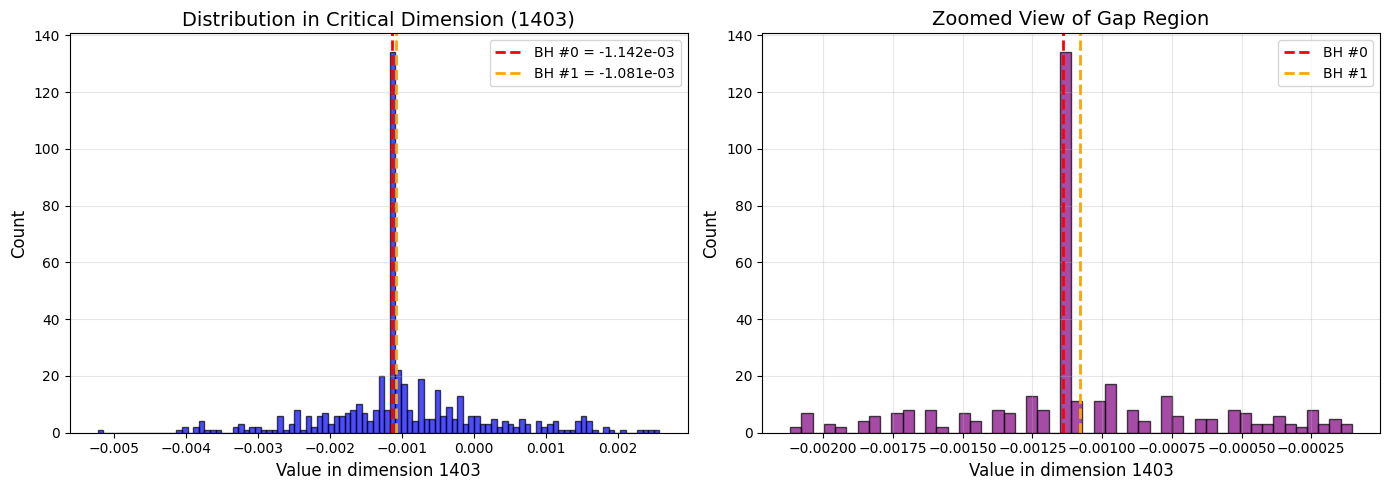

✓ Visualization complete


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: Distribution of values in critical dimension
ax = axes[0]
ax.hist(all_vals.cpu().numpy(), bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(bh0_val, color='red', linestyle='--', linewidth=2, label=f'BH #0 = {bh0_val:.3e}')
ax.axvline(bh1_val, color='orange', linestyle='--', linewidth=2, label=f'BH #1 = {bh1_val:.3e}')

# Highlight gap tokens if any
if n_in_gap > 0:
    gap_vals = all_vals[gap_indices].cpu().numpy()
    ax.scatter(gap_vals, np.zeros_like(gap_vals), color='green', s=100, 
               marker='^', label=f'{n_in_gap} gap tokens', zorder=5)

ax.set_xlabel(f'Value in dimension {critical_dim}', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Distribution in Critical Dimension ({critical_dim})', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Zoomed view of the gap
ax = axes[1]
zoom_min = min_val - 0.001
zoom_max = max_val + 0.001
in_zoom = (all_vals >= zoom_min) & (all_vals <= zoom_max)
zoom_vals = all_vals[in_zoom].cpu().numpy()

if len(zoom_vals) > 0:
    ax.hist(zoom_vals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax.axvline(bh0_val, color='red', linestyle='--', linewidth=2, label='BH #0')
    ax.axvline(bh1_val, color='orange', linestyle='--', linewidth=2, label='BH #1')
    
    if n_in_gap > 0:
        gap_vals = all_vals[gap_indices].cpu().numpy()
        for val in gap_vals:
            ax.axvline(val, color='green', linestyle=':', linewidth=1, alpha=0.7)
    
    ax.set_xlabel(f'Value in dimension {critical_dim}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Zoomed View of Gap Region', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No tokens in zoom range', ha='center', va='center', 
            transform=ax.transAxes, fontsize=14)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary

In [10]:
print("="*80)
print("THE TOKEN IN THE GAP - SUMMARY")
print("="*80)
print()
print(f"BH #0 and BH #1 separation: {distances[bh0_idx, bh1_idx].item():.6e} (2.00× ε)")
print(f"Critical dimension:         {critical_dim}")
print(f"Max difference:             {max_diff:.6e}")
print()
print(f"Tokens found in gap:        {n_in_gap}")
if n_in_gap > 0:
    print(f"  Within {SEARCH_TOLERANCE}× ε of both BHs: {n_near_both}")
    if n_near_both > 0:
        print()
        print("  🎯 LATTICE STRUCTURE CONFIRMED!")
        print("     Found token(s) at ~ε from both black holes.")
        print("     This is strong evidence of discrete lattice geometry.")
    else:
        print()
        print("  ○ Tokens exist in gap but not at lattice positions.")
        print("    Gap is populated but not structured.")
else:
    print()
    print("  ✗ Gap is empty.")
    print("    The 2ε separation creates a void in token space.")
print()
print("="*80)

THE TOKEN IN THE GAP - SUMMARY

BH #0 and BH #1 separation: 6.103516e-05 (2.00× ε)
Critical dimension:         1403
Max difference:             6.103516e-05

Tokens found in gap:        0

  ✗ Gap is empty.
    The 2ε separation creates a void in token space.



## Conclusion

**Key findings:**
- Identified critical dimension with 2ε separation
- Searched for tokens in the gap between BH #0 and BH #1
- Measured distances to potential lattice candidates

**Interpretation:**

**If gap is empty:**
- The 2ε separation creates a genuine void
- Black holes are isolated by discrete lattice spacing
- No token occupies the intermediate cell

**If tokens found but far from both BHs:**
- Gap is populated but not structured
- Tokens happen to fall in range but aren't at lattice positions
- No evidence of systematic lattice filling

**If tokens found at ~ε from both BHs:**
- **LATTICE STRUCTURE CONFIRMED**
- Token sits at intermediate lattice cell
- Strong evidence of discrete quantized geometry
- Black holes are nodes in a regular lattice

**Next steps:**
- If lattice found: Map the full 3D structure
- If gap empty: Investigate why this cell is unpopulated
- Decode semantic content of gap tokens (if any)